# Exercise: Comparing predictors  
![6.1.6.image](6.1.6.image.png)

(Note: The scaffold for this exercise was recently updated. If the logisticregression model has penalty = 'none' (with none as a string) this has been depreciated in sklearn. This should be changed to penalty = None for the current sklearn version. If penalty = None in your current view of the scaffold no change is necessary.)  

This exercise uses the heart disease dataset to ask a counterfactual-based question when comparing predictors in a logistic regression model:  
Which predictor (cholesterol, or maximum heart rate) is more likely, when altered, to change an individual's classification for heart disease? Or, asked a bit differently - which predictor is the output more sensitive to?  

It is an ongoing research question as to whether this really means a feature "matters more" to the output. In this exercise are measuring how close points are to the decision boundary in the x-direction (cholesterol) vs how close they are in the y-direction (maximum heart rate); we are not really finding out which predictor is more medically relevant to the classification of heart disease. Additionally, we are not in this exercise measuring change in both features at once - we are only changing one feature at a time - so this way of analyzing predictor sensitivity is a rough approximation of the actual sensitivity of our model to input changes.  

In [73]:
# import libraries

import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import PolynomialFeatures

In [74]:
# Read the "Heart.csv" dataset
heart = pd.read_csv('Heart.csv')

# Force the response into a binary indicator:
heart['AHD'] = 1*(heart['AHD'] == "Yes")

print(heart.shape)
# split into train and validation
heart_train, heart_val = train_test_split(heart, train_size = 0.75, random_state = 109)

print(heart_train.shape, heart_val.shape)

(303, 15)
(227, 15) (76, 15)


# Train a logistic regression model using to predict AHD from Chol and MaxHR with degree-3 polynomial features

In [75]:
predictors = ['Chol','MaxHR']

x_train = heart_train[predictors]
poly = PolynomialFeatures(degree=3,include_bias=False)
x_train_poly = poly.fit_transform(x_train)
y_train = heart_train['AHD']

lr = LogisticRegression(penalty=None, max_iter = 5000).fit(x_train_poly, y_train)
y_pred = lr.predict(x_train_poly)

print("Logistic Regression accuracy:", accuracy_score(y_train, y_pred))

Logistic Regression accuracy: 0.6784140969162996


# Visualize the decision boundary

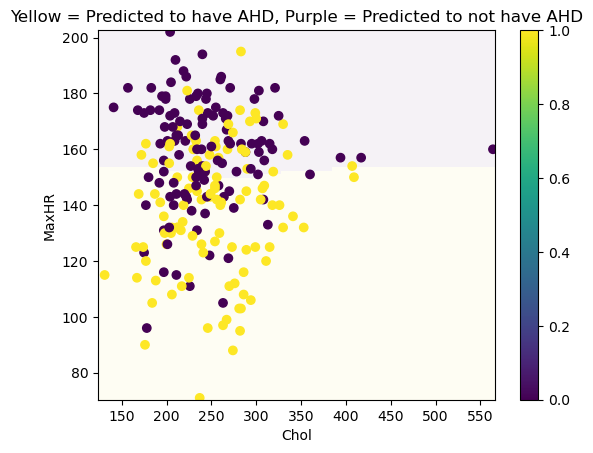

In [76]:
x1=np.linspace(heart[['Chol']].min(),heart[['Chol']].max(),100)
x2=np.linspace(heart[['MaxHR']].min(),heart[['MaxHR']].max(),100)
x1v, x2v = np.meshgrid(x1, x2)
X = np.c_[x1v.ravel(), x2v.ravel()]
X_dummy = poly.fit_transform(X)
yhat = lr.predict(X_dummy)

plt.pcolormesh(x1v, x2v, yhat.reshape(x1v.shape),alpha = 0.05) 
plt.scatter(heart_train['Chol'],heart_train['MaxHR'],c=heart_train['AHD'])
plt.ylabel("MaxHR")
plt.xlabel("Chol")
plt.title("Yellow = Predicted to have AHD, Purple = Predicted to not have AHD")
plt.colorbar()
plt.show()

# Counterfactual question: which predictor is more likely to change the outcome of the classification? MaxHR, or Chol?

In [77]:
heart.head()

,Unnamed: 0,Age,Sex,ChestPain,RestBP,Chol,Fbs,RestECG,MaxHR,ExAng,Oldpeak,Slope,Ca,Thal,AHD
0,1,63,1,typical,145,233,1,2,150,0,2.3,3,0.0,fixed,0
1,2,67,1,asymptomatic,160,286,0,2,108,1,1.5,2,3.0,normal,1
2,3,67,1,asymptomatic,120,229,0,2,129,1,2.6,2,2.0,reversable,1
3,4,37,1,nonanginal,130,250,0,0,187,0,3.5,3,0.0,normal,0
4,5,41,0,nontypical,130,204,0,2,172,0,1.4,1,0.0,normal,0


In [85]:
# print(len(y_pred_modified))
print(len(y_pred))

227


In [86]:
### edTest(test_modified_outputs) ###
# here we are going to create new dataframes based on x_train
# where we will modify each dataframe slightly
# by adding and subtracting by a standard deviation of a feature
# to see how the model outcomes change

def get_num_modified_outputs(predictor, x_change):

    #create a copy of the training data
    x_copy = x_train.copy()

    # modify the predictor by the value x_change
    x_copy[predictor] = x_copy[predictor] + x_change

    # apply the degree-3 polynomial transform to x_copy
    x_copy_poly = PolynomialFeatures(degree=3, include_bias=False).fit_transform(x_copy)
    
    # create predictions for x_copy_poly using the logistic regression model (lr)
    y_pred_modified = LogisticRegression(max_iter=len(y_train)*2).fit(x_train_poly, y_train).predict(x_copy_poly)
    
    # calculate the number of outputs that changed from y_pred to y_pred_modified
    n_changed_outputs = 0
    # compare y_pred_modified and y_train
    for i in range(len(y_train)):
        if y_pred_modified[i] != y_pred[i]:
            n_changed_outputs += 1

    return n_changed_outputs

# get standard deviation of each variable
# so that we can modify each variable
# while respecting the size/spread of that predictor in the data
# (another valid way would be to scale our data at the beginning of this exercise)
stdev_MaxHR = heart_train['MaxHR'].std()
stdev_Chol = heart_train['Chol'].std()

# get the number of modified outputs
# when modifying each variable up and down
# by 0.5 of its standard deviation
n_modify_chol_up = get_num_modified_outputs('Chol', 0.5*stdev_Chol)
n_modify_chol_down = get_num_modified_outputs('Chol', -0.5*stdev_Chol)
n_modify_maxhr_up = get_num_modified_outputs('MaxHR', 0.5*stdev_MaxHR)
n_modify_maxhr_down = get_num_modified_outputs('MaxHR', -0.5*stdev_MaxHR)

print('# outputs changed by increasing Chol:', n_modify_chol_up)
print('# outputs changed by decreasing Chol:', n_modify_chol_down)
print('# outputs changed by increasing MaxHR:', n_modify_maxhr_up)
print('# outputs changed by decreasing MaxHR:', n_modify_maxhr_down)


# outputs changed by increasing Chol: 5
# outputs changed by decreasing Chol: 5
# outputs changed by increasing MaxHR: 43
# outputs changed by decreasing MaxHR: 53


## Which feature is our model more sensitive to?

Chol (type answer = "A" in the cell below)

MaxHR (type answer = "B" in the cell below)

In [70]:
### edTest(test_sensitive_feature) ###
answer = "B"